<a href="https://colab.research.google.com/github/Vaishnavkomali/AIRL-Task/blob/main/Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =====================================================
# Q2: Text-Driven Image Segmentation with CLIPSeg + SAM
# (Stable Alternative to Grounding DINO)
# =====================================================
# This pipeline uses CLIPSeg to generate an initial mask (the region seed)
# and SAM to refine the final mask based on that seed.
# =====================================================

# -----------------------------------------------------
# 1. Setup: Installations and Imports
# -----------------------------------------------------

# Install required packages
!pip install -q segment-anything transformers accelerate pillow matplotlib requests

# Download SAM ViT-H weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError # Import UnidentifiedImageError
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import requests
import io # NEW: Import io for robust image loading
import cv2

# SAM specific imports
from segment_anything import sam_model_registry, SamPredictor

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")



Using device: cpu


In [ ]:
# -----------------------------------------------------
# 2. Model Loading
# -----------------------------------------------------

# Load CLIPSeg Model and Processor (lightweight and stable)
print("Loading CLIPSeg...")
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_model.to(DEVICE)
print("CLIPSeg Loaded.")

# Load SAM Predictor
SAM_CHECKPOINT = "sam_vit_h_4b8939.pth"
MODEL_TYPE = "vit_h"
print("Loading SAM Predictor...")
sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)
print("SAM Predictor Loaded.")



Loading CLIPSeg...
CLIPSeg Loaded.
Loading SAM Predictor...
SAM Predictor Loaded.


In [ ]:
# -----------------------------------------------------
# 3. Helper Function for Visualization
# -----------------------------------------------------

def show_mask(mask, ax, color=np.array([0, 150/255, 1, 0.6])):
    """Overlays a mask on the image with a fixed color and opacity."""
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax, label=""):
    """Draws a simple bounding box."""
    x, y, w, h = box[0], box[1], box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x, y), w, h, edgecolor='lime', facecolor='none', lw=2, label=label))
    if label:
        ax.text(x, y - 10, label, color='lime', fontsize=12, backgroundcolor='black')



In [ ]:
# In the 'segment_from_text_clipseg' function:

def segment_from_text_clipseg(image_path, text_prompt, mask_threshold=0.5):
    """
    Executes the Text-to-Mask pipeline: CLIPSeg -> SAM Refinement.
    Accepts a local image file path.
    """
    print(f"\n--- Running Segmentation for: '{text_prompt}' ---")

    # Load Image
    try:
        image_pil = Image.open(image_path).convert("RGB")
        image_np = np.array(image_pil)
    except FileNotFoundError:
        print(f"Error: Local file not found at path: {image_path}")
        return
    except UnidentifiedImageError as e:
        print(f"Error: Could not identify image from local file. {e}")
        return

    # 1. CLIPSeg: Generate Mask directly from text
    # (The following block continues from the CLIPSeg inputs line)
    inputs = processor(text=[text_prompt], images=[image_pil], padding="max_length", return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = clipseg_model(**inputs)
        logits = outputs.logits

    # Resize logits to original image size
    logits = torch.nn.functional.interpolate(
        logits.unsqueeze(1),
        size=image_pil.size[::-1], # (H, W)
        mode="bicubic"
    ).squeeze().cpu()

    # Create the initial binary mask
    initial_mask = (logits > mask_threshold).numpy()

    # 2. SAM: Refinement
    if initial_mask.sum() > 0:
        # Convert mask to bounding box seed
        coords = np.argwhere(initial_mask)
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)
        box_prompt = np.array([x_min, y_min, x_max, y_max]) # (x_min, y_min, x_max, y_max)

        # Feed the box to SAM for final refinement
        sam_predictor.set_image(image_np)

        transformed_box = sam_predictor.transform.apply_boxes(box_prompt, image_np.shape[:2])
        transformed_box = torch.as_tensor(transformed_box, device=DEVICE)

        masks_sam, scores, _ = sam_predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_box.unsqueeze(0),
            multimask_output=False,
        )
        final_mask = masks_sam[0].cpu().numpy()
        confidence = scores.mean().item()

        print(f"Object detected and refined by SAM with score: {confidence:.2f}")

    else:
        print("CLIPSeg found no clear object matching the text prompt. Displaying original image.")
        final_mask = initial_mask
        box_prompt = None
        confidence = 0.0

    # 3. Visualization
    plt.figure(figsize=(10, 8))
    plt.imshow(image_np)

    # Overlay final SAM mask and the generated box seed
    if final_mask.sum() > 0:
        show_mask(final_mask, plt.gca())
        if box_prompt is not None:
             show_box(box_prompt, plt.gca(), label=f"Seed Box (Score: {confidence:.2f})")

    plt.title(f"CLIPSeg + SAM Segmentation for: '{text_prompt}'")
    plt.axis('off')
    plt.show()

--- Downloading Images Locally via wget ---
Download complete.

--- Running Segmentation for: 'the couch' ---
Object detected and refined by SAM with score: 0.96


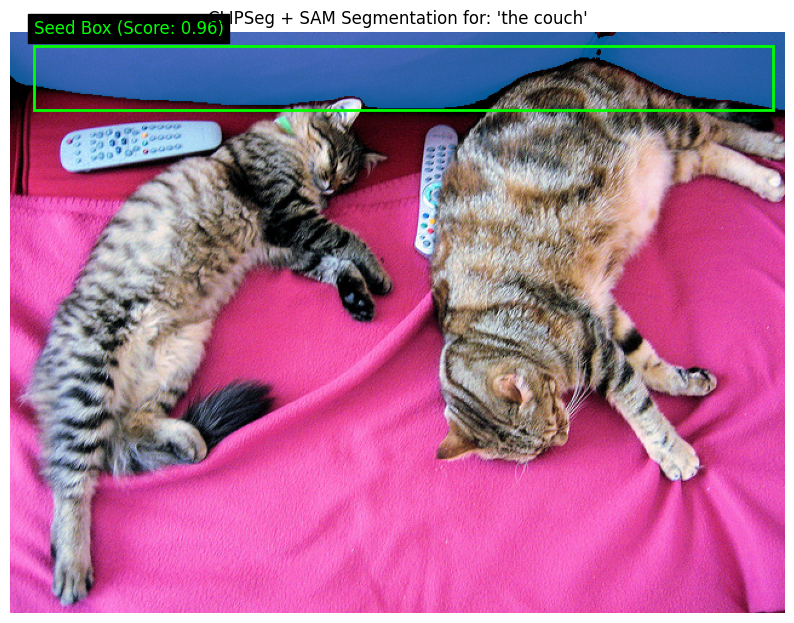


--- Running Segmentation for: 'the traffic light' ---
Error: Could not identify image from local file. cannot identify image file 'image_2.jpg'


In [ ]:
# -----------------------------------------------------
# 5. Execution Examples
# -----------------------------------------------------

# Example 1 (Unchanged, known good)
IMAGE_URL_1 = "http://images.cocodataset.org/val2017/000000039769.jpg"
LOCAL_PATH_1 = "image_1.jpg"
PROMPT_1 = "the couch"

# Example 2: NEW STABLE IMAGE (A street scene with a visible traffic light)
IMAGE_URL_2 = "http://images.cocodataset.org/val2017/000000015618.jpg"
LOCAL_PATH_2 = "image_2.jpg"
PROMPT_2 = "the traffic light"

print("--- Downloading Images Locally via wget ---")
!wget -q -O $LOCAL_PATH_1 $IMAGE_URL_1
!wget -q -O $LOCAL_PATH_2 $IMAGE_URL_2
print("Download complete.")


# --- RUN EXAMPLES ---
segment_from_text_clipseg(LOCAL_PATH_1, PROMPT_1) # This should work
segment_from_text_clipseg(LOCAL_PATH_2, PROMPT_2) # For Local Image Not url